Discrete dynamic optimal transport with dual formulation
============================================


This is an example implementation of the discretization of dynamic optimal transport introduced in the article, 

**Quantitative convergence of a discretization of dynamic optimal transport using the dual formulation**, Sadashige Ishida and Hugo Lavenant. *Foundations of Computational Mathematics*, 2024. [[arXiv]](https://arxiv.org/abs/2312.12213)

[Dependencies]  
This program is written in Jupyter (Python 3) and requires the following python libraries:  
jupyter, numpy, scipy, matplotlib

### This program has three steps:
1. Prepare settings.
2. Compute dynamic optimal transport.
3. Visualize and analyze computation results.

[Visualization of data]  
Many quantities can be visualized by toggling **visualize{Something}** variables in several cells.


## 1. Prepare settings

Set up computation environments. 
The most important procedures here are discretization of the domain, measures, and differential operators.

In [312]:
# Import necessary libraries
import numpy as np
import scipy as sp
import scipy.integrate as integrate
from scipy import optimize as opt

from matplotlib import colors
from matplotlib.ticker import StrMethodFormatter
from matplotlib.pylab import plt

import json

import sys
import os
root_folder = os.getcwd()
# print("Root folder is %s" % root_folder)

# 3D plot on jupyter notebook
# %matplotlib widget

In [313]:
# Global setup for computation

# Division of time-domain
NT=16*4
NTplus1=NT+1
NTNX_rate=1

# Division of space-domain
NX=int(NT*NTNX_rate)
NV=NTplus1*NX

dt=1.0/NT
dx=1.0/NX
print("Discretizataion parameters are \n(dt,dx,NTplus1,NX)=({},{},{},{})".format(dt,dx,NTplus1,NX))

# The time domain is [0,1]
# The space domain is [-0.5,0.5] with identification -0.5~0.5
xl=-0.5 
xr=0.5 

# Parameter used for the viscosity coefficient
theta=0.25
visc_eps=theta*dx*dx/dt

# Clamping threshold for the forward gradient 
ClampR=0.5

Discretizataion parameters are 
(dt,dx,NTplus1,NX)=(0.015625,0.015625,65,64)


In [314]:
# Densities and omega
# Choose one of the below examples or write your own example

# Make sure withContinuousOptimizers=True only when you know 
# true optimal cost and space-time optimizers (potentials, velosity, and measures)
# like examples A and B below

# A. Test case 1 in the article
# Cosine with offset to uniform distribution to 
# density_name,phiOmega,withContinuousOptimizers="smoothcos_density",1,True

# B. Test case 2 in the article
# Triangular function expanding in time
density_name,phiOmega,withContinuousOptimizers="triangular_densities",0.2,True

# C. Test case 3 in the article
# Two unimodal characteristic functions breaking apart between each other
# density_name,phiOmega,withContinuousOptimizers="characteristic_densities",0.05,True

# The below two examples are computation only from initial and final measures
# With such an example, you do not have to know a priori true space-time optimizers.
# So make sure withContinuousOptimizers=False
# D. Two Gaussians
# density_name,phiOmega,phiOmega1,mean,mean1,withContinuousOptimizers="gaussian",0.1,0.2,0,0.5,False

# E. Dirac delta like Gaussians
# density_name,phiOmega,phiOmega1,mean,mean1,withContinuousOptimizers="gaussian",0.01*dx,0.01*dx,0,0.5,False

In [315]:
# Settings for visualizations by pylab
ticks_font_size=22
title_font_size=22
legend_font_size=22
label_font_size=22

plt.rcdefaults()
plt.rcParams['text.usetex']=True
plt.rcParams['font.family'] = 'Computer Modern'#'Times New Roman' 

extent = (0,1,xr,xl)

In [316]:
# Directories to store computational data and plots
save_result_as_json=False

rawname=density_name+str(phiOmega)+"th"+str(theta)+"v2"
record_dir=root_folder+"/records/"+rawname+"/"
plot_dir=record_dir+"plots"

os.makedirs(plot_dir, exist_ok=True)
# print("Plots will be stored at ", plot_dir)

sizename="T"+str(NTplus1)+"X"+str(NX)
data_name=rawname+sizename

In [317]:
# Space densities for space measures
def gaussian1D(mean,sig,x):
    dist=np.minimum(np.abs(x-mean),1.0-np.abs(x-mean)) 
    return np.exp(-0.5*(dist/sig)**2)

def characteristic(left,right,x):
    return np.float32(left<=x)*np.float32(x<=right)

def triangular(width,x):
    return np.maximum(width-np.abs(x),0.0)/(width**2)

def bump(width,x):
    K=np.where(np.abs(x)<width,(1-(x**2/width**2)) ,-1)
    return np.where(np.abs(x)<width, np.exp(-1/K) ,0) 

In [318]:
# Space-time densities, phi, v, and costs for the above examples A and B.
def tri_space_time_dens(x,t,omega):
    W=(1+t)*omega
    return 1/W**2*np.maximum(W-np.abs(x),0)

def tri_phi(t,x,omega):
    return 0.5*x**2/(1+t)
    
def tri_v(t,x,omega):
    return x/(1+t)
    
def tri_cost(omega):
    return omega**2/12.0
    
def splitchar_space_time_dens(x,t,omega):
    slope=0.5-omega
    return 1.0/(2.0*omega)*np.array(np.abs(x)-t*slope>=0,dtype=float)*np.array(np.abs(x)-t*slope<=omega,dtype=float)

def splitchar_phi(t,x,omega):
    slope=0.5-omega
    return np.abs(x)*slope-0.5*slope*slope*t

def splitchar_v(t,x,omega):
    slope=0.5-omega
    return np.where(x ==-0.5, 0 ,np.sign(x)*slope )
    
def splitchar_cost(omega):
    slope=0.5-omega
    return slope**2/2.0


def smoothcos_space_time_dens(x,t,omega=1.0):
    y0=x    
    y= opt.newton(smoothcos_v_fn, y0,fprime=smoothcos_v_fn_drive, args=(t,x,),full_output=0)

    return 1.0+(1.0-t)/2.0*np.cos(2*omega*np.pi*y)/(1+t*0.5*np.cos(2*omega*np.pi*y))


def smoothcos_v_fn(y,t,x,omega=1.0):
    
    return  y+t/(4*np.pi*omega)*np.sin(2*np.pi*omega*y)-x
    
def smoothcos_v_fn_drive(y,t,x,omega=1.0):
    
    return  1.0 +t/2.0*np.cos(2*np.pi*omega*y)
    
def smoothcos_v(t,x,omega):

    # Fetch y := T_t^{-1}(x_t)from t and x_t.
    y0=x
    y= opt.newton(smoothcos_v_fn, y0,fprime=smoothcos_v_fn_drive, args=(t,x,),full_output=0)    
    return +1/(4*omega*np.pi)*np.sin(2*np.pi*omega*y)
    
def smoothcos_cost(omega):
    
    return 0.5*0.5/(4*omega*np.pi)**2


# set up here density, phi_func, nabla_phi
if withContinuousOptimizers:
    if density_name=="triangular_densities":
        space_time_density=lambda x,t: tri_space_time_dens(x,t,phiOmega) 
        phi_func=lambda t,x:tri_phi(t,x,phiOmega) 
        v_vec=lambda t,x:tri_v(t,x,phiOmega)
        true_cost=tri_cost(phiOmega)
        vmx=1/phiOmega
    elif density_name=="characteristic_densities":
        space_time_density=lambda x,t: splitchar_space_time_dens(x,t,phiOmega)
        phi_func=lambda t,x:splitchar_phi(t,x,phiOmega)
        v_vec=lambda t,x:splitchar_v(t,x,phiOmega)
        true_cost=splitchar_cost(phiOmega)
        vmx=0.5/phiOmega
    elif density_name=="smoothcos_density":
        space_time_density=lambda x,t: smoothcos_space_time_dens(x,t,phiOmega)
        phi_func=False
        v_vec=lambda t,x:smoothcos_v(t,x,phiOmega)
        true_cost=smoothcos_cost(phiOmega)
        vmn=0.0
        vmx=1.5
    mu_density=lambda x: space_time_density(x,0,)
    nu_density=lambda x: space_time_density(x,1,)
# if continuous optimizers are unknown, set only mu and nu.
else:
    if density_name=="gaussian":
        mu_density=lambda x:gaussian1D(mean,phiOmega,x)
        nu_density=lambda x:gaussian1D(mean1,phiOmega1,x)
        vmx=-1

In [319]:
# Discretization of time-space domain
t = np.linspace(0, 1, NTplus1)
x = np.linspace(xl, xr-dx, NX)
    
# ij indexing option is important, otherwise f(t,x) becomes f[x,t]
T, X = np.meshgrid(t, x,indexing='ij')

# Convert matrix index to array index
def idx(t,x):
    return NX*t+x

In [320]:
def discretize_space_time_density(density,T,X,):
    NTplus1,NX=T.shape
    piRho_grid=np.zeros((NTplus1,NX))
    dx=1.0/NX
    
    print("Discretization of probability density started.")
    for it in range(NTplus1):
        for ix in range(NX):

            if ix==0:
                resL=integrate.quad(density,-0.5, -0.5+0.5*dx,args=(T[it,ix],))[0]
                resR=integrate.quad(density,0.5-0.5*dx, 0.5,args=(T[it,ix],))[0]
                piRho_grid[it,ix]=resL+resR
            else:
                res=integrate.quad(density,X[it,ix]-0.5*dx, X[it,ix]+0.5*dx,args=(T[it,ix],))[0]
                piRho_grid[it,ix]=res

            j=idx(it,ix)
            if j>1 and j%10000==0:
                print("Discretization {}/{} done.".format(j,NTplus1*NX))
    print("Discretization of probability density completed.")
    return piRho_grid  

def discretize_space_only_density(space_density,x,):
    NX=len(x)
    piDens=np.zeros((NX))
    dx=1.0/NX
    
    print("Discretization of probability density started.")

    for ix in range(NX):

        if ix==0:
            resL=integrate.quad(space_density,-0.5, -0.5+0.5*dx,args=())[0]
            resR=integrate.quad(space_density,0.5-0.5*dx, 0.5,args=())[0]
            piDens[ix]=resL+resR
        else:
            res=integrate.quad(space_density,x[ix]-0.5*dx, x[ix]+0.5*dx,args=())[0]
            piDens[ix]=res

    print("Discretization of probability density completed.")
    return piDens         

In [321]:
# Discretize measures 
if withContinuousOptimizers:
    PiRho_grid=discretize_space_time_density(space_time_density,T,X,)
else:
    PiRho_grid=np.zeros((NTplus1,NX))

    PiRho_grid[0,:]=discretize_space_only_density(mu_density,x)
    PiRho_grid[NT,:]=discretize_space_only_density(nu_density,x)
    
# Normalization. Should not be needed
sum_mu=np.sum(PiRho_grid[0,:])
sum_nu=np.sum(PiRho_grid[NT,:])

sum_rho=np.sum(PiRho_grid,axis=1)
sum_mu=sum_rho[0]
sum_nu=sum_rho[NT]

print('The total volumes of PiMu,PiNu are {},{} before normalization.'.format(sum_mu,sum_nu))

if withContinuousOptimizers:
    for it in range(NT+1):
        PiRho_grid[it,:]/=sum_rho[it] 
else:
    PiRho_grid[0,:]/=sum_rho[0] 
    PiRho_grid[NT,:]/=sum_rho[NT] 
del sum_rho

Discretization of probability density started.
Discretization of probability density completed.
The total volumes of PiMu,PiNu are 1.0000000000137015,1.0000000000137015 before normalization.


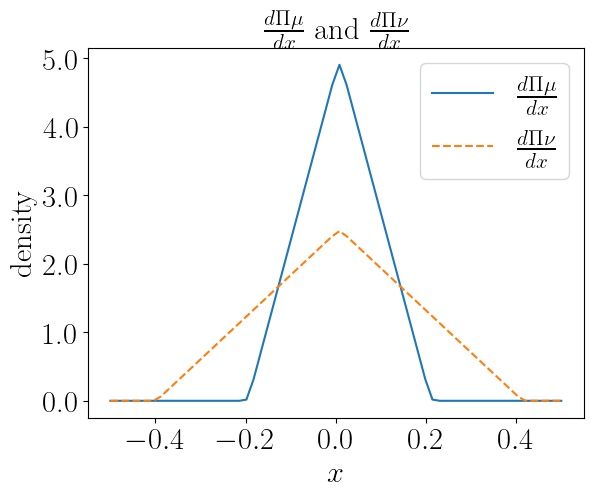

In [322]:
visualizeMuAndNu=False
visualizePiMuAndPiNu=True

if visualizeMuAndNu and withContinuousOptimizers:
    fig, ax = plt.subplots()
    
    plt.plot(np.linspace(xl,xr,NX),mu_density(x),linestyle='solid')
    plt.plot(np.linspace(xl,xr,NX),nu_density(x),linestyle='dashed')

    ax.legend([r"$\frac{d\mu}{dx}$", r"$\frac{d\nu}{dx}$"],fontsize=legend_font_size)

    plt.xticks(fontsize=ticks_font_size);
    plt.yticks(fontsize=ticks_font_size);
    plt.xlabel('$x$',size=label_font_size)
    plt.ylabel(r'density',size=label_font_size)

    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 2 decimal places

    plt.title(r"Point sample of $\frac{d\mu}{dx}$ and $\frac{d\nu}{dx}$",fontsize=title_font_size)
    plt.show()
        
if visualizePiMuAndPiNu:
    fig, ax = plt.subplots()

    plt.plot(np.linspace(xl,xr,NX),PiRho_grid[0,:]/dx,linestyle='solid')
    plt.plot(np.linspace(xl,xr,NX),PiRho_grid[NT,:]/dx,linestyle='dashed')

    ax.legend([r"$\frac{d\Pi\mu}{dx}$", r"$\frac{d\Pi\nu}{dx}$"],fontsize=legend_font_size)
    
    plt.xticks(fontsize=ticks_font_size);
    plt.yticks(fontsize=ticks_font_size);
    plt.xlabel('$x$',size=label_font_size)
    plt.ylabel(r'density',size=label_font_size)

    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 2 decimal places

    plt.title(r"$\frac{d\Pi\mu}{dx}$ and $\frac{d\Pi\nu}{dx}$",fontsize=title_font_size)
    plt.show()

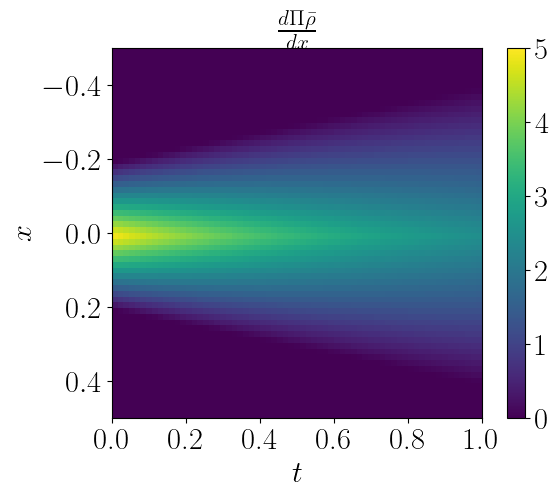

In [323]:
visualizeTrueDensity=False
visualizePiTrueDensity=True

if visualizeTrueDensity and withContinuousOptimizers:
    fig, ax = plt.subplots()

    TrueDensity=space_time_density(X,T,)

    if not ('vmn' in locals()):
        vmn=0
    if vmx>0:
        im=ax.imshow(TrueDensity.T,extent=extent, vmin=vmn, vmax=vmx)
    else:
        im=ax.imshow(TrueDensity.T,extent=extent, )
    
    plt.xlabel('$t$',size=label_font_size)
    plt.ylabel('$x$',size=label_font_size)

    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))
    
    plt.xticks(fontsize=ticks_font_size);
    plt.yticks(fontsize=ticks_font_size);
    
    plt.title(r"Point sample of $\frac{d\bar\rho}{dx}$",fontsize=title_font_size)    
    cb=fig.colorbar(im,)

    cb.ax.tick_params(labelsize=ticks_font_size)

    # Save plot
    # plt.savefig(plot_dir+"/"+sizename+"rho_GT.png",bbox_inches='tight',dpi=1200) 

if visualizePiTrueDensity and withContinuousOptimizers:
    fig, ax = plt.subplots()

    if not ('vmn' in locals()):
        vmn=0
    if vmx>0:
        im=ax.imshow(PiRho_grid.T/dx,extent=extent, vmin=vmn, vmax=vmx)
    else:
        im=ax.imshow(PiRho_grid.T/dx,extent=extent, vmin=vmn)
    
    plt.xlabel('$t$',size=label_font_size)
    plt.ylabel('$x$',size=label_font_size)
    
    
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))
    
    plt.xticks(fontsize=ticks_font_size);
    plt.yticks(fontsize=ticks_font_size);
    
    plt.title(r"$\frac{d\Pi\bar\rho}{dx}$",fontsize=title_font_size)
    
    cb=fig.colorbar(im)
    cb.ax.tick_params(labelsize=ticks_font_size)

In [324]:
# Construct discrete differential operators
LaplacianCoef=1.0/(dx*dx)

sigma_t_size=NT*NX
sigma_x_size=sigma_t_size
sigma_R_size=NX

colsAT=[]
rowsAT=[]
valuesAT=[]

colsAX=[]
rowsAX=[]
valuesAX=[]

colsAR=[]
rowsAR=[]
valuesAR=[]

print("Started construction of discrete differential operator.")

for ti in range(NT):
    for xi in range(NX):

        ind=idx(ti,xi)
        t_next = (ti+1)%NTplus1
        x_prev = (xi-1)%NX
        x_next = (xi+1)%NX
           
        rowsAT.append(ind)
        colsAT.append(idx(t_next,xi))
        valuesAT.append(1.0/dt)

        rowsAT.append(ind)
        colsAT.append(ind)
        valuesAT.append(-1.0/dt)
            
        rowsAX.append(ind)
        colsAX.append(idx(ti,x_next))
        valuesAX.append(.5/dx)
        rowsAX.append(ind)
        colsAX.append(idx(ti,x_prev))
        valuesAX.append(-.5/dx)             
        
        rowsAT.append(ind)
        colsAT.append(ind)
        valuesAT.append(+visc_eps*LaplacianCoef*2.0)
        rowsAT.append(ind)
        colsAT.append(idx(ti,x_prev))
        valuesAT.append(-visc_eps*LaplacianCoef*1.0)
        rowsAT.append(ind)
        colsAT.append(idx(ti,x_next))
        valuesAT.append(-visc_eps*LaplacianCoef*1.0)
        
        if ti==0:
            rowsAR.append(ind)
            colsAR.append(idx(ti,x_next))
            valuesAR.append(1./dx)
            rowsAR.append(ind)
            colsAR.append(ind)
            valuesAR.append(-1./dx)
        
        j=idx(ti,xi)
        if j>1 and j%10000==0:
            print("Collecting entries of discrete differential operator  {}/{} done.".format(j,NT*NX))

print("Build discrete differential operator from sparse data.")

AT=sp.sparse.csc_matrix((valuesAT, (rowsAT,colsAT)), shape=(sigma_t_size, NV))
AX=sp.sparse.csc_matrix((valuesAX, (rowsAX,colsAX)), shape=(sigma_x_size, NV))
AR=sp.sparse.csc_matrix((valuesAR, (rowsAR,colsAR)), shape=(sigma_R_size, NV))
A=sp.sparse.vstack((AT,AX,AR))
        
LHS=dt*dx*A.T@A
LHS=sp.sparse.csc_matrix(LHS)
LinearSolver=sp.sparse.linalg.factorized(LHS)

print("Completed construction of discrete differential operator.")

del colsAT
del rowsAT
del valuesAT

del colsAX
del rowsAX
del valuesAX

del colsAR
del rowsAR
del valuesAR

del LHS

Started construction of discrete differential operator.
Build discrete differential operator from sparse data.
Completed construction of discrete differential operator.


In [325]:
# Set price functional for the dual value of OT
FD=np.zeros(PiRho_grid.shape)

FD[0,:] = - PiRho_grid[0,:]
FD[NT,:] =  PiRho_grid[NT,:]
    
# a bit sophisticated version
# for xi in range(NX):
#     x_prev = (xi-1)%NX
#     x_next = (xi+1)%NX
#     FD[0,xi]= -0.25*(PiRho_grid[0,x_prev]+PiRho_grid[0,x_next]+2.0*PiRho_grid[0,xi])
#     FD[NT,xi]= 0.25*(PiRho_grid[NT,x_prev]+PiRho_grid[NT,x_next]+2.0*PiRho_grid[NT,xi])

FD.resize((NV))

In [326]:
# Dual value and primal value
def dual_value(phai,FdeltaPhi):
    return FdeltaPhi.T@phai

def primal_value(density,momentum,dual_clamp,dt,dx,K=0.0):
    nonzero_dens_ind=np.nonzero(np.maximum(density,0))[0]
    kinetic_energy=np.sum(0.5*momentum[nonzero_dens_ind]*momentum[nonzero_dens_ind]/density[nonzero_dens_ind]*dt*dx)
    clamp_cost= np.sum(np.abs(dual_clamp))*K*dx*dt
    
    return kinetic_energy+clamp_cost,kinetic_energy,clamp_cost

# Action subject to extremization in ADMM framework
def ActionADMM(phai,sigmau,Lambdaa,Dif,F_D,dt,dx,r):
    dual_cost=dual_value(phai,F_D)
    gap_cost=-r/2.0*dt*dx*((Dif@phai-sigmau+Lambdaa).T@(Dif@phai-sigmau+Lambdaa)-Lambdaa.T@Lambdaa)
    return dual_cost+gap_cost

In [327]:
# Functions and derivatives for Newton's method used in ADMM framework
def hn(lam,t0,x0):
        return np.maximum((2*t0-lam)+ 4*x0**2.0/(2+lam)**2,0.0)

def hnderiv(lam,t0,x0):
        return -1 -(8*x0**2)/(2 + lam)**3

def hnderiv2nd(lam,t0,x0):
        return -(24*x0**2)/(2 + lam)**4

## 2. Compute dynamic optimal transport

Solve the discrete dynamic optimal transport using the alternating direction method of multipliers (ADMM).

Alternatively computation can be made by any convex optimization framework like [CVXPY](https://www.cvxpy.org/) although it is slower.

In [328]:
# ADMM parameters
stepsize= 1.0
max_iteration=60000
ending_threshold=1e-5 #1e-5
show_intermediate_log=True

# You can load previous compution result for large data
load_phi_Lambda= False and NTplus1>500
phi_file=record_dir+data_name+"phi"
Lambda_file=record_dir+data_name+"Lambda"
if load_phi_Lambda:
    phi=np.load(phi_file+".npy")
    Lambda=np.load(Lambda_file+".npy")
    print("Load phi file '{}.npy'".format(phi_file))
    print("Load Lambda file '{}.npy'".format(Lambda_file))

# Also you can save intermediate result and reuse it later.
temp_save= False and NTplus1>500

In [329]:
# ADMM loop
if not load_phi_Lambda:
    Lambda=np.zeros(sigma_t_size+sigma_x_size+sigma_R_size)
    phi=np.zeros(NV)
    
sigma=np.zeros(sigma_t_size+sigma_x_size+sigma_R_size)
lams=np.zeros(sigma_t_size)

print("Started ADMM computation.")
for i in range(max_iteration):

    if show_intermediate_log and i%100==1:     

        dv=dual_value(phi,FD)
        pv,kinetic_energy,clamp_cost=primal_value(Lambda[:sigma_t_size],Lambda[sigma_t_size:sigma_t_size+sigma_t_size],Lambda[sigma_t_size+sigma_x_size:],dt,dx,ClampR)
        Action=ActionADMM(phi,sigma,Lambda,A,FD,dt,dx,stepsize)

        print("Iteration=",i,"Action=",Action,"\ndual_value=",dv," primal_value=",pv," duality_gap=", pv-dv,\
         "\n(kinetic energy,clamp_cost)=",(kinetic_energy,clamp_cost),)
     
    if (not load_phi_Lambda) or i>0:
        RHS=dt*dx*A.T@(sigma-Lambda)
        RHS+=1.0/stepsize*FD
        phi=LinearSolver(RHS)

    sigma=A@phi+Lambda

    lams=np.zeros(sigma_t_size)

    sigma_t=sigma[:sigma_t_size]    
    sigma_x=sigma[sigma_t_size:2*sigma_t_size]
    sigma_R=sigma[sigma_t_size+sigma_x_size:sigma_t_size+sigma_x_size+NX]
    sigma[sigma_t_size+sigma_x_size:sigma_t_size+sigma_x_size+NX]=np.clip(sigma_R,-ClampR,ClampR)
        
    # Newton method without 2nd derivative
    lams = opt.newton(hn,lams, fprime=hnderiv, args=(sigma_t,sigma_x,),full_output=0)
    
    # Newton method with 2nd derivative
    # lams = opt.newton(hn,lams, fprime=hnderiv, fprime2=hnderiv2nd, args=(sigma_t,sigma_x,),full_output=0)
    
    sigma_t+=-lams/2.0
    sigma_x*=2/(2.0+lams)

    Lambda_old=np.array(Lambda)
    Lambda = Lambda+A@phi-sigma
    
    if i%100==1:
          
        primal_residual=A@phi-sigma
        dual_residual=stepsize*A.T@(Lambda_old-Lambda)
        prim_redisual_L2=np.sum(np.square(primal_residual))*dt*dx
        dual_residual_L2=np.sum(np.square(dual_residual))*dt*dx
        
        if show_intermediate_log:
            print("primal residual=",prim_redisual_L2,"dual residual=",dual_residual_L2,"\n")
        if prim_redisual_L2<ending_threshold and dual_residual_L2<ending_threshold:
            print("Finished ADMM computation since the primal and dual residuals became smaller than the threshold ",ending_threshold)
            break            
    
    if temp_save and (i>0 and i%1000==0):
        phi_temp_file=record_dir+data_name+"ite"+str(i)+"phi"
        np.save(phi_temp_file,phi)

        Lambda_temp_file=record_dir+data_name+"ite"+str(i)+"Lambda"
        np.save(Lambda_temp_file,Lambda)
        if show_intermediate_log:
            print("Save temporary computation of phi as {}.npy",phi_temp_file)
            print("Save temporary computation of Lambda as {}.npy",Lambda_temp_file)
    


Started ADMM computation.
Iteration= 1 Action= -0.5414995337004311 
dual_value= 1.3713198213618554  primal_value= 0.025541658675078606  duality_gap= -1.3457781626867769 
(kinetic energy,clamp_cost)= (0.02042198815318732, 0.005119670521891285)
primal residual= 0.03137077371404794 dual residual= 4.003007202468976 

Iteration= 101 Action= 0.006601612526293401 
dual_value= 0.006807275808453719  primal_value= 0.006592119301655838  duality_gap= -0.00021515650679788077 
(kinetic energy,clamp_cost)= (0.006557622262255674, 3.449703940016399e-05)
primal residual= 3.666690391181496e-07 dual residual= 1.0248317928038845e-06 

Finished ADMM computation since the primal and dual residuals became smaller than the threshold  1e-05


In [330]:
# Save computed phi and Lambda
save_phi_Lambda=False
if save_phi_Lambda:
    phi_file=record_dir+data_name+"phi"
    Lambda_file=record_dir+data_name+"Lambda"
    np.save(phi_file,phi)
    np.save(Lambda_file,Lambda)
    print("Computed phi saved as '{}.npy'".format(phi_file))
    print("Computed Lambda saved as '{}.npy'".format(Lambda_file))

## 3. Visualize and analyze computation results

Visualize and analyze dual and primal optimizers. Also measure the deviation from the continuous optimal transport.  

In [331]:
# Show computational results
phi_grid=phi.reshape((NTplus1,NX))
rho_grid=(Lambda[:sigma_t_size]).reshape((NT,NX))

dv=dual_value(phi,FD)
pv,_,_=primal_value(Lambda[:sigma_t_size],Lambda[sigma_t_size:sigma_t_size+sigma_t_size],Lambda[sigma_t_size+sigma_x_size:],dt,dx,ClampR)   
print("dual value=",dv, " primal value=",pv, "\nduality gap=", pv-dv)

APhi=A@phi
AtPhi=AT@phi 
AxPhi=AX[:(NT)*NX]@phi

# Value for the discrete Hamilton-Jacobi 
HJ=AtPhi+0.5*(AxPhi*AxPhi)

print("Rho min =", np.min(Lambda[:sigma_t_size]),"Rho max =",np.max(Lambda[:sigma_t_size]))
print("HJ min =",np.min(HJ)," HJ max =",np.max(HJ))
print( "min gradient (all t) =",np.min(AxPhi), "max gradient (all t) =",np.max(AxPhi),)
print( "min gradient (t<1) =",np.min(AxPhi[:NT,]), "max gradient (t<1) =",np.max(AxPhi[:NT,]),)

dual value= 0.006801646419767232  primal value= 0.006591860508785943 
duality gap= -0.0002097859109812892
Rho min = 0.0 Rho max = 4.69073508378887
HJ min = -0.1541464946004496  HJ max = 0.002182403356766116
min gradient (all t) = -0.5148782723699652 max gradient (all t) = 0.5148782723698515
min gradient (t<1) = -0.5000244357223611 max gradient (t<1) = 0.5000244357223647


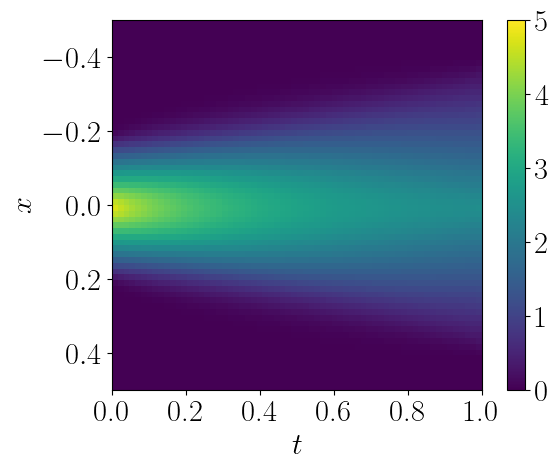

In [332]:
VisualizeRho=True
if VisualizeRho:
    fig, ax = plt.subplots()

    if not ('vmn' in locals()):
        vmn=0
    if vmx>0:
        im=ax.imshow(rho_grid.T,extent=extent,vmin=vmn, vmax=vmx)
    else:
        im=ax.imshow(rho_grid.T,extent=extent,vmin=vmn,)
    
    plt.xlabel('$t$',size=label_font_size)
    plt.ylabel('$x$',size=label_font_size)
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))
    
    plt.xticks(fontsize=ticks_font_size);
    plt.yticks(fontsize=ticks_font_size);
    
    cb=fig.colorbar(im)
    cb.ax.tick_params(labelsize=ticks_font_size)
     
    # Save plot
    # plt.savefig(plot_dir+"/"+sizename+"rho.png",bbox_inches='tight',dpi=1200) 

Dual cost for optimal potential =  0.006801646419767232
Dual cost for discrete HJ solution =  0.006593045585281121


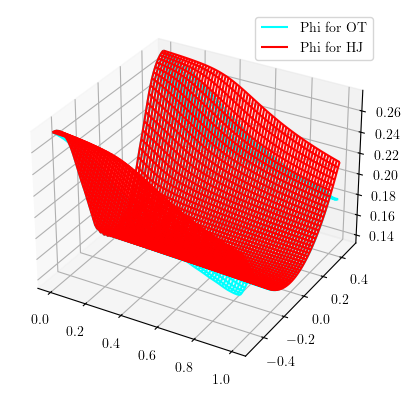

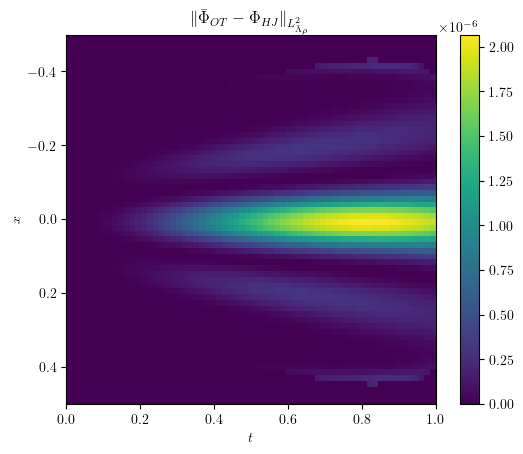

In [333]:
# Compare with the solution to the discrete Hamilton-Jacobi equation 
# with initial data phi[0,x]

# Solve forward HJ for comparison with optimal potential to discrete OT.
def Ham(v,K=-1):
    
    if K<0 or abs(v)<=K:
        return 0.5*v*v
    else:
        if v>K:
            return -0.5*K*K+K*v
        elif v<-K:
            return -0.5*K*K-K*v
            
phi_HJ_grid=np.zeros(phi_grid.shape)

# Set
phi_HJ_grid[0,:]=phi_grid[0,:]

for ti in range(0,NT):    
    for xi in range(0,NX):
        t_next = (ti+1)%NTplus1
        x_prev = (xi-1)%NX
        x_next = (xi+1)%NX

        px=0.5*(phi_HJ_grid[ti,x_next]-phi_HJ_grid[ti,x_prev])/dx
        pxx=phi_HJ_grid[ti,x_next]+phi_HJ_grid[ti,x_prev]-2.0*phi_HJ_grid[ti,xi]

        phi_HJ_grid[t_next,xi]=phi_HJ_grid[ti,xi]-dt*1.*Ham(px,-1)+theta*pxx


Visualize_OT_and_HJ_Phis=True
if Visualize_OT_and_HJ_Phis:
    plt.figure()
    ax = plt.subplot(projection='3d')
    ax.plot_wireframe(T, X, phi_grid,rstride=1, cstride=1,color='cyan', label='Phi for OT')
    ax.plot_wireframe(T[:,:], X[:,:], phi_HJ_grid[:,:],rstride=1, cstride=1,color='red', label='Phi for HJ')
    ax.legend()
    
    plt.figure()
    
    ax = plt.axes()
    im=ax.imshow((rho_grid[:NT,:]*(phi_HJ_grid[:NT,:]-phi_grid[:NT,:])**2).T,extent=extent)
    plt.xlabel("$t$")
    plt.ylabel("$x$")
    plt.title(r"$\|\bar\Phi_{OT} - \Phi_{HJ}\|_{L^2_{\bar\Lambda_\rho}} $")
    cb=plt.colorbar(im)

phi_HJ=phi_HJ_grid.reshape(phi.shape)
dv_HJ=dual_value(phi_HJ,FD)

print("Dual cost for optimal potential = ", dv)
print("Dual cost for discrete HJ solution = ", dv_HJ)

In [334]:
# Compute deviation from the optimizers to continuous OT
if withContinuousOptimizers:
    
    # cost error
    error_cost=np.abs(dv-true_cost)

    AXphi_grid=(AX@phi).reshape((NT,NX))

    # velocity error
    vel_gap=AXphi_grid-v_vec(T[:NT,:],X[:NT,:],)
    L2gapVelVal=vel_gap*vel_gap*rho_grid
    error_V=np.sum(L2gapVelVal*dt*dx)

    # phi error
    if phi_func:
        PhiCont=phi_func(T,X,).reshape(NTplus1*NX)
        AxPhiCont_grid=(AX@PhiCont).reshape(NT,NX)
        gap=1.0*AXphi_grid-1.0*AxPhiCont_grid
        L2gapPot_grid=gap*gap*rho_grid
        error_phi=np.sum(L2gapPot_grid*dt*dx)
    else: 
        error_phi=np.NaN

    # rho error
    L1gapRho_grid=np.abs(rho_grid-PiRho_grid[:NT,:]/dx)*dt*dx
    # psampleRho=space_time_density(X,T)
    # L1gapRho_grid=np.abs(rho_grid-psampleRho[:NT,:])*dt*dx
    error_rho=np.sum(L1gapRho_grid)

    print("Errors:\nerror_cost={:.3e}, error_V={:.3e}, error_phi={:.3e}, error_rho={:.6e} ".format(error_cost,error_V,error_phi,error_rho))

Errors:
error_cost=3.468e-03, error_V=1.142e-03, error_phi=1.142e-03, error_rho=4.274631e-02 


In [335]:
VisualizeErrors=False

if VisualizeErrors and withContinuousOptimizers:

    fig, ax = plt.subplots()
    im=ax.imshow(L2gapVelVal.T,extent=extent)

    fig.colorbar(im)
    plt.xlabel('$t$')
    plt.ylabel('$x$')
    plt.title(r"Error $v$")
    
    if phi_func:
        fig, ax = plt.subplots()
        im=ax.imshow(L2gapPot_grid.T,extent=extent)
        fig.colorbar(im)
        plt.xlabel('$t$')
        plt.ylabel('$x$')
        plt.title(r"Error $\varphi$")

    fig, ax = plt.subplots()
    im=ax.imshow(L1gapRho_grid.T,extent=extent)

    fig.colorbar(im)
    plt.xlabel('$t$')
    plt.ylabel('$x$')
    plt.title(r"Error $\rho$")

In [336]:
# Show and save computed information
if withContinuousOptimizers:
    print("--Computation information--")

    data=dict()
    data["name"]=data_name
    data["NTplus1"]=NTplus1
    data["NX"]=NX
    data["ClampR"]=ClampR
    data["theta"]=theta
    data["visc_eps"]=visc_eps
    data["cost"]=dv
    data["true_cost"]=true_cost
    data["error_cost"]=np.abs(dv-true_cost)
    data["error_V"]=error_V
    data["error_phi"]=error_phi
    data["error_rho"]=error_rho

    jsonfile=record_dir+data_name+".json"
    if save_result_as_json:
        with open(jsonfile, 'w') as f:
            json.dump(data, f, indent=2)

    for key,val in data.items():
        if key in ["error_cost","error_V","error_phi","error_rho"]:
            print(key,":","{:.4e}".format(val))
        else:
            print(key,":",val)

    # print("Saved information as ",jsonfile)

--Computation information--
name : triangular_densities0.2th0.25v2T65X64
NTplus1 : 65
NX : 64
ClampR : 0.5
theta : 0.25
visc_eps : 0.00390625
cost : 0.006801646419767232
true_cost : 0.003333333333333334
error_cost : 3.4683e-03
error_V : 1.1418e-03
error_phi : 1.1418e-03
error_rho : 4.2746e-02
